<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/05_Transfer_learning_in_TensorFlow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, in this notebook we will go through a new kind of transfer learning: fine-tuning

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np

import os
import random


In [2]:
# Check if we are using a GPU
!nvidia-smi

Thu Jan 13 06:22:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

It is a good idea, to put functions that you will use a lot in a script, that you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions previously used here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-13 06:22:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-13 06:22:47 (63.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## The data

This time we will see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognising images of food)
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of food 101

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-01-13 06:22:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2022-01-13 06:22:48 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
unzip_data("10_food_classes_10_percent.zip")

In [8]:
# check how many images and subdirectories in the dataset

In [9]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [10]:
# Create training and test 

In [11]:
train_dir = "10_food_classes_10_percent/train" 
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (254,254)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 254, 254, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check the class names of the dataset

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [5.84411888e+01 5.84411888e+01 5.04411888e+01]
   [6.41971283e+01 6.31971321e+01 5.81971321e+01]
   [6.74528503e+01 6.64528503e+01 6.24528503e+01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [5.81352577e+01 5.81352577e+01 5.01352577e+01]
   [6.00988426e+01 5.90988426e+01 5.40988426e+01]
   [5.99291344e+01 5.89291344e+01 5.49291344e+01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [5.62531357e+01 5.62531357e+01 4.82531357e+01]
   [5.96095390e+01 5.86095390e+01 5.36095390e+01]
   [6.05590553e+01 5.95590553e+01 5.55590553e+01]]

  ...

  [[1.54000000e+02 1.37000000e+02 1.17000000e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the keras functional API.

---



The sequential API is straightforward, it runs the layers in sequential order.

However, the functional API  gives more flexiability with models.
link: https://www.tensorflow.org/guide/keras/functional?hl=en

**1.** Create a base model with tf.keras.applications.

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step




---



**2**. Freeze the base model (so the underlying pre-trained patterns aren't updated during training).

In [ ]:
base_model.trainable = False



---






**3**. Create inputs in to the model.

In [ ]:
inputs = tf.keras.layers.Input(shape=(254,254,3), name='input_layer')





---






**4**. If using ResNet50V2 you will need to normalise inputs (you don't have to for EffecientNet(s)).


In [ ]:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)



---



**5**. Pass the inputs to the base_model.

In [ ]:
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape} ")

Shape after passing inputs through base model: (None, 7, 7, 1280) 




---





**6**. Average pool the outputs of the base model (aggregate all the most importantinformation, reduce number of computations). 

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2d: {x.shape}")

Shape after GlobalAveragePooling2d: (None, 1280)




---

**7**. Create the output activation layer.

In [ ]:
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)



---

**8**. Combine the inputs with the outputs into a model.

In [ ]:
model_0 = tf.keras.Model(inputs,outputs)



---

**9**. Compile the model

In [ ]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



---



**10**. Fit the model and save the history

In [ ]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")]
                                 )

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220102-034239


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 28s 479ms/step - loss: 1.9074 - accuracy: 0.3827 - val_loss: 1.3322 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 8s 309ms/step - loss: 1.1410 - accuracy: 0.7373 - val_loss: 0.9090 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 8s 301ms/step - loss: 0.8471 - accuracy: 0.8013 - val_loss: 0.7485 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 8s 302ms/step - loss: 0.6841 - accuracy: 0.8400 - val_loss: 0.6611 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 8s 302ms/step - loss: 0.5786 - accuracy: 0.8613 - val_loss: 0.5966 - val_accuracy: 0.8405


In [ ]:
# Evaluate on the full test data

model_0.evaluate(test_data)

79/79 [==============================] - 14s 167ms/step - loss: 0.6091 - accuracy: 0.8420


[0.6090877652168274, 0.8420000076293945]

In [ ]:
# Check the layers in the base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Summary of the whole model

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 254, 254, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


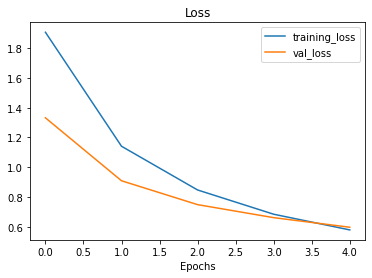

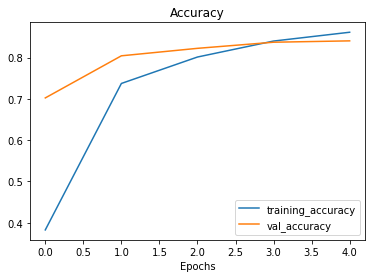

In [ ]:
# Check the model'straining curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Demonstrating the Global Average Pooling 2D layer...

We have a Tensor after the model goes through `base-model` of shape (None, 7, 7, 1280).

Then when it passes through GlobalAveragePooling2D it turns into (None,1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

print(f"Random input tensor:\n {input_tensor} \n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 



In [ ]:
# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D Global average pooled random tensor:\n {global_average_pooled_layer} \n")

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 



In [ ]:
# Check the shape of the different tensors
print(f"Shape of input tensors: {input_tensor.shape}")
print(f"Shape of global tensor: {global_average_pooled_layer.shape}")

Shape of input tensors: (1, 4, 4, 3)
Shape of global tensor: (1, 3)


In [ ]:
# Replicating the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension **feature vector**.

🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

### What is a feature vector?

A feature vector is **a learned representation of the input data** (a compressed form of the input data based on how the model see's it) 

## Running a series of transfer learning experiments

We have saw the results transfer learning can get with only 10% of the training data. However, now we will experiment and see how well it does with only 1% with a series of experiments such as:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation. 

**Note**: Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1




In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")



--2022-01-02 03:44:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   191MB/s    in 0.7s    

2022-01-02 03:44:19 (191 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent/train")

There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.


In [ ]:
# Setup data loaders 

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)




Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

To add data augmentation into the models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` 

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


The data augmentation transformations we're going to use are:

* RandomFlip - flips image on horizontal or vertical axis.
* RandomRotation - randomly rotates image by a specified amount.
* RandomZoom - randomly zooms into an image by specified amount.
* RandomHeight - randomly shifts image height by a specified amount.
* RandomWidth - randomly shifts image width by a specified amount.
* Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the tf.keras.applications implementation of EfficientNetB0, it's not required.

For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [ Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the
[TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [ ]:
# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.

data_augmentation = keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      #preprocessing.Rescale(1./255) Keep for models like ResNet50v2 but EffecientNet's have rescaling built-in
], name="data_augmentation")

### Visualise the data augmentation layer (and see what happens to the data)

In [ ]:
# View a random image and compare it to the augmented image.

target_class = random.choice(train_data_1_percent.class_names)

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
target_dir = "10_food_classes_1_percent/train/" + target_class

In [ ]:
print(target_dir)

10_food_classes_1_percent/train/fried_rice


In [ ]:
random_image = random.choice(os.listdir(target_dir))

In [ ]:
print(random_image)

1369712.jpg


In [ ]:
random_image_path = target_dir + '/' + random_image

In [ ]:
print(random_image_path)

10_food_classes_1_percent/train/fried_rice/1369712.jpg


In [ ]:
# Read in the random image

img = mping.imread(random_image_path)

In [ ]:
print(img)

[[[104  97  71]
  [104  97  71]
  [103  96  70]
  ...
  [ 22  14   3]
  [ 21  13   2]
  [ 18  12   0]]

 [[102  95  69]
  [102  95  69]
  [102  95  69]
  ...
  [ 21  13   2]
  [ 20  12   1]
  [ 17   9   0]]

 [[102  95  69]
  [102  95  69]
  [101  94  68]
  ...
  [ 19  10   1]
  [ 18   9   0]
  [ 15   6   0]]

 ...

 [[ 61  48  13]
  [ 62  49  14]
  [ 64  51  16]
  ...
  [ 61  49  25]
  [ 62  50  24]
  [ 60  48  22]]

 [[ 64  51  16]
  [ 65  52  17]
  [ 67  54  19]
  ...
  [ 61  49  25]
  [ 63  51  25]
  [ 60  48  22]]

 [[ 66  53  18]
  [ 67  54  19]
  [ 69  56  21]
  ...
  [ 63  51  27]
  [ 64  52  26]
  [ 62  51  23]]]


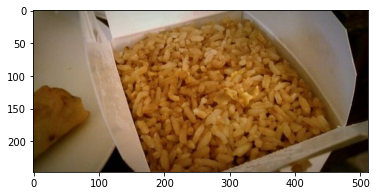

In [ ]:
plt.imshow(img)

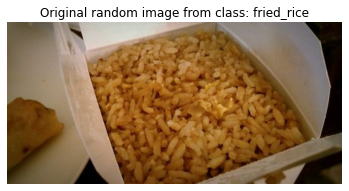

In [ ]:
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

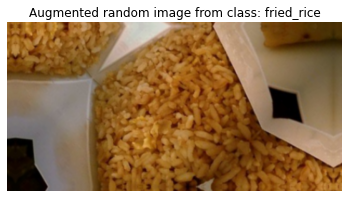

In [ ]:
# Now plot the augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img / 255.));


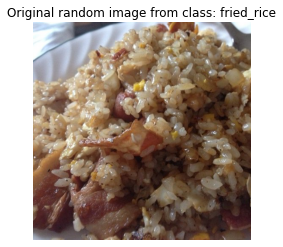

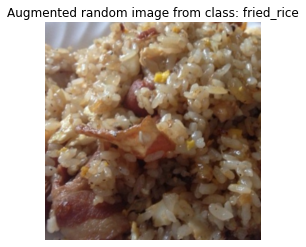

In [ ]:
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

img = mping.imread(random_image_path)

plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img / 255.));




## Model 1: Feature extraction transfer learning on 1 percent of the data with data augmentation.

Setup input shape and base model, freezing the base model layers

In [ ]:
# MAKE THE MODEL

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# Create input layers
inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features on the base model
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

# Put a dense layer on as an output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a model using the inputs and the outputs 
model_1 = keras.Model(inputs, outputs)


# COMPILE THE MODEL

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# FIT THE MODEL

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')]
                                )

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220102-034427
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 14s 3s/step - loss: 2.4262 - accuracy: 0.0714 - val_loss: 2.2472 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1915 - accuracy: 0.2000 - val_loss: 2.1184 - val_accuracy: 0.2648
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0324 - accuracy: 0.3714 - val_loss: 2.0292 - val_accuracy: 0.3043
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8023 - accuracy: 0.5286 - val_loss: 1.9311 - val_accuracy: 0.3569
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6643 - accuracy: 0.6286 - val_loss: 1.8452 - val_accuracy: 0.4062


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full training dataset

results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 133ms/step - loss: 1.8269 - accuracy: 0.4412


[1.8269072771072388, 0.44119998812675476]

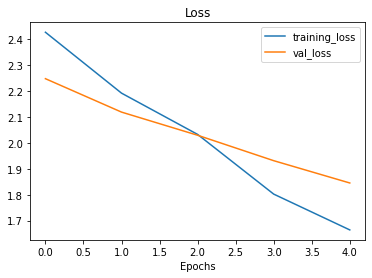

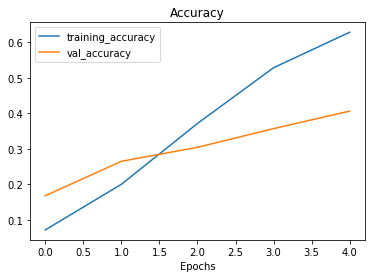

In [ ]:
# How does the model with 1% of the data augmentation loss curve look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of the data with data augmentation

In [12]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-01-13 06:23:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2022-01-13 06:23:09 (164 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [13]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

### Set up data inputs. 

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE) 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### See how many images are in the directories.

In [15]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

### Create model 2 with data augmentation built in.

#### Build data augmentation layer

In [16]:
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2),
                                #preprocessing.Rescaling(1./255)  commented out, as EffecientNet has rescaling built in.
                              ], name="data_augmentation")



In [17]:
# set up the input shape to our model
input_shape = (224, 224, 3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  

base_model.trainable = False

# Create the inputs and the outputs (including the layers inbetween)
inputs = layers.Input(shape=input_shape, name='input_layer')
X = data_augmentation(inputs)  # augment the training images (augmentation does not occur on test data)
X = base_model(X, training=False) # pass the augmented images to the base model but keep it in inference mode, this also insures that batchnorm layers dont get updated
X = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(X)

outputs = layers.Dense(10, activation="softmax", name='output_layer')(X)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



16719872/16705208 [==============================] - 0s 0us/step


In [18]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating a ModelCheckpoint callback.

**What are callbacks?**
* Callbacks are tools which can add helpful functionality to your models during training,evaluation or inferance.
* Some popular callbacks include:
    * TensorBoard.
    * Model checkpointing.
    * Early Stopping.


The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [19]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

### Fit Model 2 passing in the ModelCheckpoint callback

In [20]:
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback]) 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220113-062320
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 2.0084 - accuracy: 0.3333
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 35s 816ms/step - loss: 2.0084 - accuracy: 0.3333 - val_loss: 1.4693 - val_accuracy: 0.6694
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3512 - accuracy: 0.6640
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 684ms/step - loss: 1.3512 - accuracy: 0.6640 - val_loss: 1.0241 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0659 - accuracy: 0.7320
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 621ms/step - loss: 1.0659 - accuracy: 0.7320 - val_loss: 0.8258 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8945 - accuracy: 

In [21]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 138ms/step - loss: 0.6830 - accuracy: 0.8144


[0.6829719543457031, 0.8144000172615051]

In [22]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6830 - accuracy: 0.8144


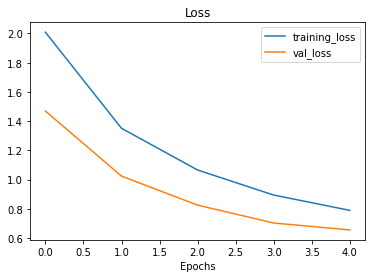

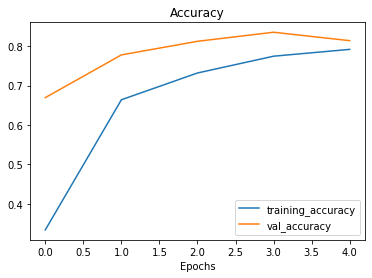

In [23]:
# plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [24]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [25]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [26]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.6830 - accuracy: 0.8144


In [27]:
# If the results from the previous augmented model_2 match the loaded weights, everything has worked.
results_10_percent_data_aug == loaded_weights_model_results 

False

In [28]:
results_10_percent_data_aug

[0.6829720139503479, 0.8144000172615051]

In [29]:
loaded_weights_model_results

[0.6829721927642822, 0.8144000172615051]

🔑 **NOTE**: 🔑 This is due to how computers store numbers and its precision

In [30]:
# Check to see if loaded model results are very close to our previous non-loaded model results.
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [31]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note**: Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data. 

### What layers are in the base_model (EffecientNetB0) and are they trainable? 

In [32]:
# Layers in loaded model
model_2.layers

In [33]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer)
  print(layer.trainable)
  print('\n')

True


True


False


True


True




In [34]:
for layer in model_2.layers[2].layers:
  print(layer.name)
  print(layer.trainable)
  print('\n')

input_1
False


rescaling
False


normalization
False


stem_conv_pad
False


stem_conv
False


stem_bn
False


stem_activation
False


block1a_dwconv
False


block1a_bn
False


block1a_activation
False


block1a_se_squeeze
False


block1a_se_reshape
False


block1a_se_reduce
False


block1a_se_expand
False


block1a_se_excite
False


block1a_project_conv
False


block1a_project_bn
False


block2a_expand_conv
False


block2a_expand_bn
False


block2a_expand_activation
False


block2a_dwconv_pad
False


block2a_dwconv
False


block2a_bn
False


block2a_activation
False


block2a_se_squeeze
False


block2a_se_reshape
False


block2a_se_reduce
False


block2a_se_expand
False


block2a_se_excite
False


block2a_project_conv
False


block2a_project_bn
False


block2b_expand_conv
False


block2b_expand_bn
False


block2b_expand_activation
False


block2b_dwconv
False


block2b_bn
False


block2b_activation
False


block2b_se_squeeze
False


block2b_se_reshape
False


block2b_se_reduce
False


In [35]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name)
  print(layer.trainable)
  print('\n')

0 input_1
False


1 rescaling
False


2 normalization
False


3 stem_conv_pad
False


4 stem_conv
False


5 stem_bn
False


6 stem_activation
False


7 block1a_dwconv
False


8 block1a_bn
False


9 block1a_activation
False


10 block1a_se_squeeze
False


11 block1a_se_reshape
False


12 block1a_se_reduce
False


13 block1a_se_expand
False


14 block1a_se_excite
False


15 block1a_project_conv
False


16 block1a_project_bn
False


17 block2a_expand_conv
False


18 block2a_expand_bn
False


19 block2a_expand_activation
False


20 block2a_dwconv_pad
False


21 block2a_dwconv
False


22 block2a_bn
False


23 block2a_activation
False


24 block2a_se_squeeze
False


25 block2a_se_reshape
False


26 block2a_se_reduce
False


27 block2a_se_expand
False


28 block2a_se_excite
False


29 block2a_project_conv
False


30 block2a_project_bn
False


31 block2b_expand_conv
False


32 block2b_expand_bn
False


33 block2b_expand_activation
False


34 block2b_dwconv
False


35 block2b_bn
False


36 bloc

### How many trainable variables are in the base_model?

In [36]:
print(len(model_2.layers[2].trainable_variables))

0


### Fine-tuning the last 10 layers of the base_model

> 🔑 **Note** : When fine-tuning it is best practice to lower your learning rate by some amount. How much? This is a hyper parameter you can tune. A good rule of thumb is at 10x (though different sources will claim other values).

One resource for information on this and transfer learning is:
[Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)

In [37]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile the model every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),   #When fine-tuning you typically want to lower the learning rate by 10 x
                metrics=['accuracy'])

In [38]:
# Now there should be some unfrozen layers (the last 10).
print(len(model_2.trainable_variables))

12


In [39]:
print(len(model_2.layers[2].trainable_variables))
# previously this was 0

10


### Fine-tune for another 5 epochs

In [40]:
fine_tune_epochs = initial_epochs + 5

# refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from the previous last epoch 
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220113-062537


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 27s 713ms/step - loss: 0.6980 - accuracy: 0.7987 - val_loss: 0.5153 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 16s 670ms/step - loss: 0.5817 - accuracy: 0.8213 - val_loss: 0.5009 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 13s 520ms/step - loss: 0.5287 - accuracy: 0.8347 - val_loss: 0.4782 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 14s 553ms/step - loss: 0.4551 - accuracy: 0.8587 - val_loss: 0.4756 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 12s 486ms/step - loss: 0.3959 - accuracy: 0.8813 - val_loss: 0.4686 - val_accuracy: 0.8438
Epoch 10/10
24/24 [==============================] - 13s 522ms/step - loss: 0.3990 - accuracy: 0.8907 - val_loss: 0.4864 - val_accuracy: 0.8306


### Evaluate the fine-tuned model (model_3 which is actually just model_2 but fine-tuned with another 5 epochs) 

In [41]:
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.4939 - accuracy: 0.8288


In [42]:
results_10_percent_data_aug

[0.6829720139503479, 0.8144000172615051]

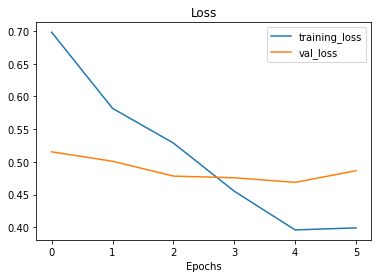

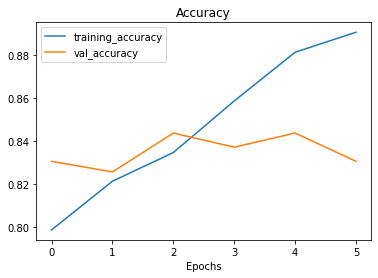

In [43]:
# Check out the loss curves of the fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works with models which have only been fit once, however, we would like something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).



In [47]:
# Create a function to compare training histories.

def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflow history objects
  """
  # Get original history measurements.
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start fine-tuning')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

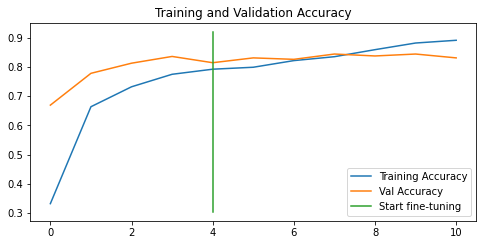

In [48]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug)

In [50]:
# Create a function to compare training histories.

def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflow history objects
  """
  # Get original history measurements.
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start fine-tuning')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')


  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start fine-tuning')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

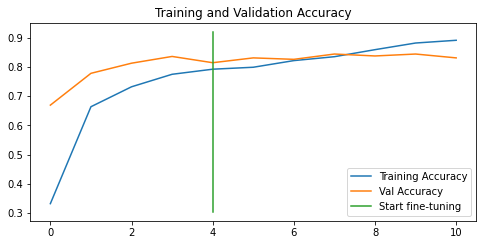

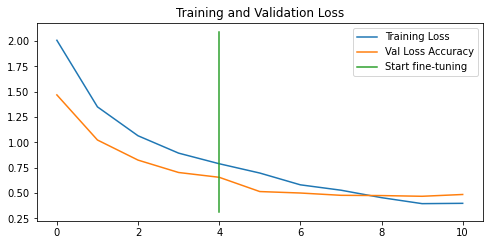

In [51]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug)